<a href="https://colab.research.google.com/github/pourzand/Facial-Landmark-Detection-with-Deeplabv3-DSNT/blob/main/ashwhall%20Demo%20using%20DeepLabV3%2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# DSNT

'''
A Tensorflow implementation of the DSNT layer, as taken from the paper "Numerical Coordinate
Regression with Convolutional Neural Networks"
'''

import tensorflow as tf

def dsnt(inputs, method='softmax'):
    '''
    Differentiable Spatial to Numerical Transform, as taken from the paper "Numerical Coordinate
    Regression with Convolutional Neural Networks"
    Arguments: 
        inputs - The learnt heatmap. A 3d tensor of shape [batch, height, width]
        method - A string representing the normalisation method. See `_normalise_heatmap` for available methods
    Returns:
        norm_heatmap - The given heatmap with normalisation/rectification applied
        coords_zipped - A tensor of shape [batch, 2] containing the [x, y] coordinate pairs
    '''
    # Rectify and reshape inputs
    norm_heatmap = _normalise_heatmap(inputs, method)
    
    batch_count = tf.shape(norm_heatmap)[0]
    height = tf.shape(norm_heatmap)[1]
    width = tf.shape(norm_heatmap)[2]

    # Build the DSNT x, y matrices
    dsnt_x = tf.tile([[(2 * tf.range(1, width+1) - (width + 1)) / width]], [batch_count, height, 1])
    dsnt_x = tf.cast(dsnt_x, tf.float32)
    dsnt_y = tf.tile([[(2 * tf.range(1, height+1) - (height + 1)) / height]], [batch_count, width, 1])
    dsnt_y = tf.cast(tf.transpose(dsnt_y, perm=[0, 2, 1]), tf.float32)

    # Compute the Frobenius inner product
    outputs_x = tf.reduce_sum(tf.multiply(norm_heatmap, dsnt_x), axis=[1, 2])
    outputs_y = tf.reduce_sum(tf.multiply(norm_heatmap, dsnt_y), axis=[1, 2])

    # Zip into [x, y] pairs
    coords_zipped = tf.stack([outputs_x, outputs_y], axis=1)

    return norm_heatmap, coords_zipped

def js_reg_loss(heatmaps, centres, fwhm=1):
    '''
    Calculates and returns the average Jensen-Shannon divergence between heatmaps and target Gaussians.
    Arguments:
        heatmaps - Heatmaps generated by the model
        centres - Centres of the target Gaussians (in normalized units)
        fwhm - Full-width-half-maximum for the drawn Gaussians, which can be thought of as a radius.
    '''
    gauss = _make_gaussians(centres, tf.shape(heatmaps)[1], tf.shape(heatmaps)[2], fwhm)
    divergences = _js_2d(heatmaps, gauss)
    return tf.reduce_mean(divergences)


def _normalise_heatmap(inputs, method='softmax'):
    '''
    Applies the chosen normalisation/rectification method to the input tensor
    Arguments:
        inputs - A 4d tensor of shape [batch, height, width, 1] (the learnt heatmap)
        method - A string representing the normalisation method. One of those shown below
    '''
    # Remove the final dimension as it's of size 1
    inputs = tf.reshape(inputs, tf.shape(inputs)[:3])

    # Normalise the values such that the values sum to one for each heatmap
    normalise = lambda x: tf.div(x, tf.reshape(tf.reduce_sum(x, [1, 2]), [-1, 1, 1]))

    # Perform rectification
    if method == 'softmax':
        inputs = _softmax2d(inputs, axes=[1, 2])
    elif method == 'abs':
        inputs = tf.abs(inputs)
        inputs = normalise(inputs)
    elif method == 'relu':
        inputs = tf.nn.relu(inputs)
        inputs = normalise(inputs)
    elif method == 'sigmoid':
        inputs = tf.nn.sigmoid(inputs)
        inputs = normalise(inputs)
    else:
        msg = "Unknown rectification method \"{}\"".format(method)
        raise ValueError(msg)
    return inputs

def _kl_2d(p, q, eps=24):
    unsummed_kl = p * (tf.compat.v1.log(p + eps) - tf.compat.v1.log(q + eps))
    kl_values = tf.reduce_sum(unsummed_kl, [-1, -2])
    return kl_values

def _js_2d(p, q, eps=1e-24):
    m = 0.5 * (p + q)
    return 0.5 * _kl_2d(p, m, eps) + 0.5 * _kl_2d(q, m, eps)

def _softmax2d(target, axes):
    '''
    A softmax implementation which can operate across more than one axis - as this isn't
    provided by Tensorflow
    Arguments:
        targets - The tensor on which to apply softmax
        axes - An integer or list of integers across which to apply softmax
    '''
    max_axis = tf.reduce_max(target, axes, keepdims=True)
    target_exp = tf.exp(target-max_axis)
    normalize = tf.reduce_sum(target_exp, axes, keepdims=True)
    softmax = target_exp / normalize
    return softmax

def _make_gaussian(size, centre, fwhm=1):
        '''
        Makes a rectangular gaussian kernel.
        Arguments:
            size - A 2d tensor representing [height, width]
            centre - Pair of (normalised [0, 1]) x, y coordinates 
            fwhm - Full-width-half-maximum, which can be thought of as a radius.
        '''
        # Scale the normalised coordinates to be relative to the size of the frame
        centre = [centre[0] * tf.cast(size[1], tf.float32), 
                  centre[1] * tf.cast(size[0], tf.float32)]
        # Find the largest side, as we build a square and crop to desired size
        square_size = tf.cast(tf.reduce_max(size), tf.float32)

        x = tf.range(0, square_size, 1, dtype=tf.float32)
        y = x[:,tf.newaxis]
        x0 = centre[0] - 0.5
        y0 = centre[1] - 0.5
        unnorm = tf.exp(-4*tf.compat.v1.log(2.) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)[:size[0],:size[1]]
        norm = unnorm / tf.reduce_sum(unnorm)
        return norm

def _make_gaussians(centres_in, height, width, fwhm=1):
    '''
    Makes a batch of gaussians. Size of images designated by height, width; number of images
    designated by length of the 1st dimension of centres_in
    Arguments:
        centres_in - The normalised coordinate centres of the gaussians of shape [batch, x, y]
        height - The desired height of the produced gaussian image
        width - The desired width of the produced gaussian image
        fwhm - Full-width-half-maximum, which can be thought of as a radius.
    '''
    def cond(centres, heatmaps):
        return tf.greater(tf.shape(centres)[0], 0)
    
    def body(centres, heatmaps):
        curr = centres[0]
        centres = centres[1:]
        new_heatmap = _make_gaussian([height, width], curr, fwhm)
        new_heatmap = tf.reshape(new_heatmap, [-1])
        
        heatmaps = tf.concat([heatmaps, new_heatmap], 0)
        return [centres, heatmaps]
    
    # Produce 1 heatmap per coordinate pair, build a list of heatmaps
    _, heatmaps_out = tf.while_loop(cond,
                                    body,
                                    [centres_in, tf.constant([])],
                                    shape_invariants=[tf.TensorShape([None, 2]), tf.TensorShape([None])])
    heatmaps_out = tf.reshape(heatmaps_out, [-1, height, width])
    return heatmaps_out

# Differentiable Spatial to Numerical Transform
An example of the usage of the DSNT layer, as taken from the paper "Numerical Coordinate Regression with Convolutional Neural Networks"

In [ ]:
# Imports
import tensorflow as tf
import cv2
import numpy as np



import matplotlib.pyplot as plt
%matplotlib inline


# !pip install dm-sonnet tqdm
# import sonnet as snt
# print(snt.__version__)

# Import for us of the transform layer and loss function
# import dsnt

# For the Sonnet Module
# from dsnt_snt import DSNT

## Build some dummy data
Circles of random colour, size and position on a black background


200 images total
training: 150
testing : 50


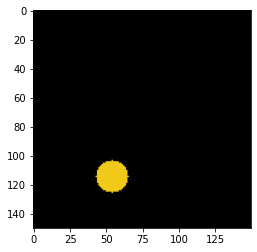

In [ ]:
img_size = 150
image_count = 200
train_percent = 0.75
train_image_count = int(train_percent * image_count)
test_image_count = image_count - train_image_count

images = []
targets = []
for _ in range(200):
    img = np.zeros((img_size, img_size, 3))
    row, col = np.random.randint(0, img_size), np.random.randint(0, img_size)
    radius = np.random.randint(8, 15)
    b, g, r = np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255)
    cv2.circle(img, (row, col), radius, (b, g, r), -1)
    images.append(img)
    norm_row = row / img_size
    norm_col = col / img_size
    targets.append([norm_row, norm_col])

images = np.array(images)
targets = np.array(targets)
train_images = images[:train_image_count]
test_images = images[train_image_count:]
train_targets = targets[:train_image_count]
test_targets = targets[train_image_count:]

print('''
{} images total
training: {}
testing : {}'''.format(image_count, train_image_count, test_image_count))

plt.imshow(train_images[0].astype('uint8'))


## A simple model
A handful of convolutional layers, each time downsampling by a factor of 2.
The network finishes with a kernel-size 1 convolution, producing a single channel heat-map.
I'm an advocate of [Deepmind's Sonnet](https://github.com/deepmind/sonnet), so the convolution operations are written using this. It's quite obvious what the equivalent Tensorflow operations would be.

In [ ]:
def inference(inputs):
  # just replace any instace of "snt" with "tf.keras.layers"

  #kernel_shape in sonnet is equivalent ot kernel_size in tf
  #output_channels in sonnet is the same as filters in tf
  #rate in sonnet is dilation_rate in tf
    inputs = tf.keras.layers.Conv2D(filters=166,
                        kernel_size=3,
                        dilation_rate=1,
                        padding='SAME',
                        name='conv1')(inputs)
    inputs = tf.nn.relu(inputs)
    inputs = tf.nn.max_pool(inputs, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    
    inputs = tf.keras.layers.Conv2D(filters=32,
                        kernel_size=3,
                        dilation_rate=2,
                        padding='SAME',
                        name='conv2')(inputs)
    inputs = tf.nn.relu(inputs)
    inputs = tf.nn.max_pool(inputs, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    
    inputs = tf.keras.layers.Conv2D(filters=64,
                        kernel_size=3,
                        dilation_rate=4,
                        padding='SAME',
                        name='conv3')(inputs)
    inputs = tf.nn.relu(inputs)
    inputs = tf.nn.max_pool(inputs, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    
    inputs = tf.keras.layers.Conv2D(filters=128,
                        kernel_size=3,
                        dilation_rate=8,
                        padding='SAME',
                        name='conv4')(inputs)
    inputs = tf.nn.relu(inputs)
    inputs = tf.nn.max_pool(inputs, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    
    inputs = tf.keras.layers.Conv2D(filters=256,
                        kernel_size=3,
                        dilation_rate=16,
                        padding='SAME',
                        name='conv5')(inputs)
    inputs = tf.nn.relu(inputs)
    inputs = tf.nn.max_pool(inputs, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    
    inputs = tf.keras.layers.Conv2D(filters=256,
                        kernel_size=3,
                        padding='SAME',
                        name='conv6')(inputs)
    inputs = tf.nn.relu(inputs)
    inputs = tf.nn.max_pool(inputs, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    
    inputs = tf.keras.layers.Conv2D(filters=1,
                        kernel_size=1,
                        padding='SAME',
                        name='conv7')(inputs)
                        
    #normally the format would be dsnt.dsnt(inputs) but since i defined dsnt above in this same notebook, we dont have to         
    coords, norm_heatmap = dsnt(inputs)

    # The Sonnet option
    # coords, norm_heatmap = DSNT()(inputs)

    print("coords")
    print(coords.shape)
    print("norm heat")

    print(norm_heatmap.shape)

    return coords, norm_heatmap

## Training
A very simple training loop with no mini-batching.

In [ ]:
tf.compat.v1.reset_default_graph()

tf.compat.v1.disable_eager_execution() # added to be compataible with v2
import sys

input_x = tf.compat.v1.placeholder(tf.float32, shape=[None, img_size, img_size, 3])
print(input_x.shape)
input_y = tf.compat.v1.placeholder(tf.float32, shape=[None, 2])

print(train_images.shape)
heatmaps, predictions = inference(input_x)
print(type(heatmaps))
print(type(predictions))
print("heatmpas here")
print(heatmaps.shape)
tf.print(predictions)

#TEMP

# The predictions are in the range [-1, 1] but I prefer to work with [0, 1]
predictions = (predictions + 1) / 2

# Coordinate regression loss
loss_1 = tf.losses.mean_squared_error(input_y, predictions)

# Regularization loss
  #normally would be dsnt.js_reg_loss
loss_2 = js_reg_loss(heatmaps, input_y)
loss = loss_1 + loss_2

# was previously tf.train.AdamOptimizer() for v1
# also had to add (var_list=None) argument to minimize

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=6e-5).minimize(loss)

print("about to begin training")
print(train_images.shape)
# print(train_images[0])

with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    for epoch in range(10):
        for i in range(train_image_count):
            curr_img = train_images[i]
            curr_target = train_targets[i]
            _, loss_val = sess.run(
                [optimizer, loss], 
                {
                    input_x: [curr_img],
                    input_y: [curr_target]
                }
            )

    def evaluate_total_mse(images, targets):
        '''
        Evaluate the mean-squared-error across the whole given batch of images, targets
        '''
        total_loss = 0
        image_count = images.shape[0]
        for i in range(image_count):
            curr_img = images[i]
            curr_target = targets[i]
            loss_val = sess.run(loss_1, {
                input_x: [curr_img],
                input_y: [curr_target]
            })
            total_loss += loss_val
        return total_loss / image_count

    print("Training MSE: ")
    print(evaluate_total_mse(train_images, train_targets))
    print("Testing MSE: ")
    print(evaluate_total_mse(test_images, test_targets))

(None, 150, 150, 3)
(150, 150, 150, 3)
coords
(None, 3, 3)
norm heat
(None, 2)
<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>
heatmpas here
(None, 3, 3)
about to begin training
(150, 150, 150, 3)
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]
Training MSE: 
[0.00402348]
Testing MSE: 
[0.00492477]


In [ ]:
print(train_images.shape)
print(train_targets.shape)
print(train_targets[0])
print("_________________________")
print(test_images.shape)
print(test_targets.shape)
print(test_targets[0])
print(int(150 * test_targets[0][0]),int(150 * test_targets[0][1]))

(150, 150, 150, 3)
(150, 2)
[0.84666667 0.03333333]
_________________________
(50, 150, 150, 3)
(50, 2)
[0.62666667 0.24666667]
94 37


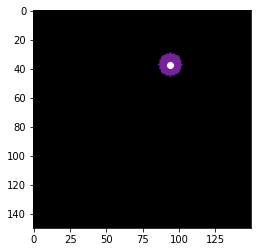

In [ ]:
plt.imshow(test_images[0].astype('uint8'))
plt.scatter((150 * test_targets[0][0]),( 150 * test_targets[0][1]),c = 'white')


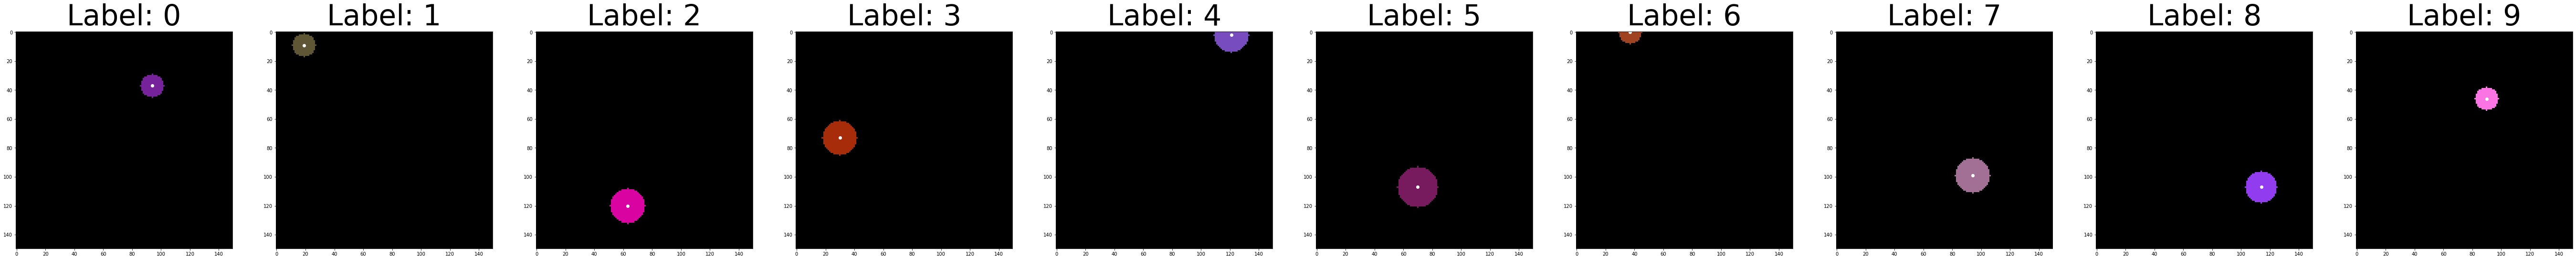

In [ ]:
f, ax = plt.subplots(1, 10, figsize=(96,96))
for i in range (0, 10) :
    # print(df.iloc[i,30].shape)
    ax[i].imshow(test_images[i].astype('uint8'))
    ax[i].scatter((150 * test_targets[i][0]),(150 * test_targets[i][1]),c = 'white')
    ax[i].set_title( "Label: {}".format(i), fontsize=60)